In [64]:
import numpy as np
import scipy.linalg as sc
import matplotlib.pyplot as plt
from scipy import signal

from MRPy import MRPy

## Introdução

Fase 01 - Modelo de 2 gdl sujeito a excitação harmônica  
Fase 02 - Amortecedor de massa ativo

## Fase 01 - Modelo de 2 gdl sujeito a excitação harmônica

## 1. Modelo

### 1.1 Parâmetros Iniciais

In [65]:
L  = 0.15
EI = 2.05e11*(0.02*0.0005**3)/12
k  = 12*EI/L/L/L

m1 = 0.4
m2 = 0.4

### 1.2 Matrizes de Rigidez e Massa (lumped)

In [66]:

# Stiffness coefficients in N/m
K = np.array ([[ 2*k, -2*k], 
               [-2*k,  4*k]])


# Lumped mass matrix in kg


M = np.array([ [m1,  0,], 
               [0,  m2,]])

print ("Matriz de rigidez\n",K)
print ("\nMatriz de Massa (lumped)\n",M)

Matriz de rigidez
 [[ 303.7037037  -303.7037037 ]
 [-303.7037037   607.40740741]]

Matriz de Massa (lumped)
 [[0.4 0. ]
 [0.  0.4]]


### 1.3 Cálculo das frequências e modos de vibrações

First vibration mode:   2.71Hz, [ 0.851  0.526]
Second vibration mode:  7.10Hz, [-0.526  0.851]


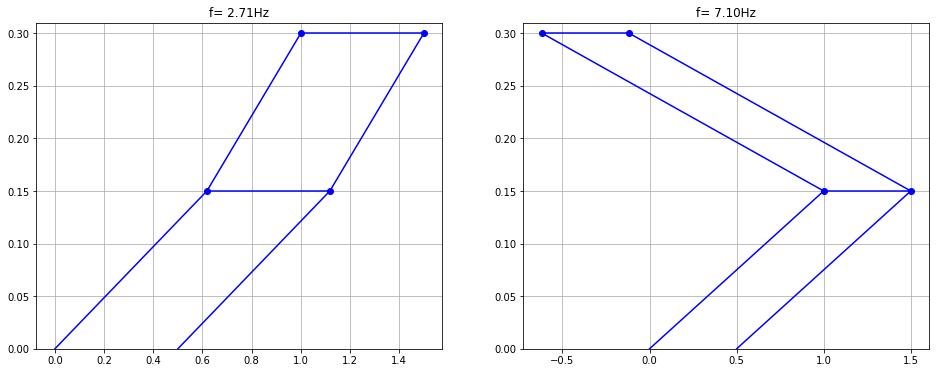

In [67]:
# Uses scipy to solve the standard eigenvalue problem
w2, Phi = sc.eig(K, M)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f}]'.format(fk[1], *Phi[:,1]))

## Plotagem dos 3 primeiros modos de vibração da estrutura
plt.figure(1, figsize=(16,6))
x = np.linspace(0,2*L,3)

for k in range(2):
    pk = np.zeros(3)
    pk[1:] = Phi[::-1,k]
    pk /=np.max(np.abs(pk))
    plt.subplot(1,2,k+1)
    
    ## Linhas Horizontais
    for n in range(2):
        o = np.linspace(pk[n+1],pk[n+1]+.5,2)
        y1 = np.ones(2)*n*L+L
        plt.plot(o, y1, 'b')
    
    ## Pontos
    plt.plot(pk[1:],x[1:],'bo')
    plt.plot(pk[1:]+.5, x[1:], 'bo')
    
    ## Linhas Verticais
    plt.plot(pk,x,'b')
    plt.plot(pk+.5, x,'b')

#    plt.xlim(-1.5, 1.5); plt.ylabel("Altura [cm]");
    plt.ylim( 0.0, 2*L+.01);
    plt.title('f= {0:3.2f}Hz'.format(fk[k]));
    plt.grid(True)

In [68]:
Mk = np.diag(np.dot(Phi.T, np.dot(M, Phi)))

print('First mode modal mass is:  {0:7.2f}kg'.format(Mk[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk[1]))

First mode modal mass is:     0.40kg
Second mode modal mass is:    0.40kg


## 2. Funcionamento do Motor (servo)

Lembretes:

ATUALIZAR

### 2.1 

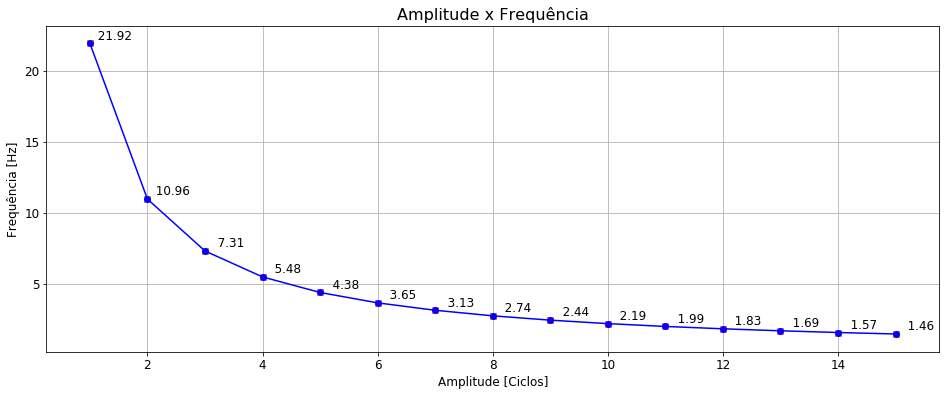

In [69]:
A=np.linspace(1,15,15)
ang = (2*np.pi/512)*A       # Amplitude do movimento [ângulo de giro]
lag_time = 0.0014258        # Tempo de atraso entre os passos
Tm = 4*A*8*lag_time         # Período do movimento
fm = 1/Tm                   # Frequência do movimento


plt.figure(2, figsize=(16,6))
plt.plot(A,fm, 'bo')
plt.plot(A,fm, 'b')
plt.title("Amplitude x Frequência", fontsize=16);
plt.xlabel("Amplitude [Ciclos]", fontsize=12)
plt.ylabel("Frequência [Hz]", fontsize=12)
plt.grid(True)
plt.tick_params(axis='x', which='major', labelsize=12)
plt.tick_params(axis='y', which='major', labelsize=12)


for i,type in enumerate(fm):
    plt.scatter(A[i], fm[i], marker='x', color='red')
    plt.text(A[i]+0.01, fm[i]+0.3, "{0:7.2f}".format(fm[i]), fontsize=12)
plt.show()

### 2.2 Definição de Parâmetros

In [70]:
A = 7                      # Amplitude do movimento [número de ciclos]
ang = (2*np.pi/512)*A       # Amplitude do movimento [ângulo de giro - rad]
L = .1                      # Comprimento da haste [m] 
D = ang*L                   # Amplitude em deslocamento horizontal [m]
lag_time = 0.0014258        # Tempo de atraso entre os passos
Tm = 4*A*8*lag_time         # Período do movimento
fm = 1/Tm                   # Frequência do movimento



print ("A aplitude do movimento é: {0:5.3f}rad".format(ang))
print ("A aplitude do movimento é: {0:5.3f}°".format(ang*180/np.pi))
print ("A aplitude do movimento é: {0:5.3f}m".format(D))
print ("O período do movimento é: {0:5.3f}s".format(Tm))
print ("A frequência do movimento é: {0:5.3f}Hz".format(fm))

A aplitude do movimento é: 0.086rad
A aplitude do movimento é: 4.922°
A aplitude do movimento é: 0.009m
O período do movimento é: 0.319s
A frequência do movimento é: 3.131Hz


## 3. Excitação Harmônica

## Fase 02 - Atenuador de massa

## Modelo 01 com atenuador de massa passivo

In [71]:
# System properties
f0 =  fk[0]                      # natural frequency (Hz)
k0 =  m1*(2*np.pi*f0)**2         # system stiffness (N/m)
zt =  0.01                       # same damping ratio for all

# Damper design
mD =  (m1+m2)*0.04                        # damper mass 4% of total (kg)
mr =  mD/(m1+m2)
sm =  np.sqrt(mr)

fr = (np.sqrt(1 - mr/2)/(1 + mr) + np.sqrt(1 - 2*zt*zt) - 1) \
       - (2.375 -  1.034*sm -  0.426*mr)*zt*sm \
       - (3.730 - 16.903*sm + 20.496*mr)*zt*zt*sm

fD =  1.00*fr*f0                 # Tsai and Lin (1993) - increase to test!!!
kD =  mD*(2*np.pi*fD)**2         # tuned damper stiffness (N/m)

print('Ideal damper frequency: {0:5.2f}Hz'.format(fD))
print (fk[0])

Ideal damper frequency:  2.57Hz
2.710363498249657


In [72]:
# Matriz de rigidez do amortecedor
KD = np.array([[    kD, -kD ],    # stiffness matrix
               [   -kD,  kD ]])

n=1                                                      #Grau de liberdade onde o amortecedor será inserido
K2=np.insert(np.insert(K, n, 0, axis=1), n, 0, axis=0)  #Inserir uma linha e uma coluna de zeros (matriz de ordem 12)
M2=np.insert(np.insert(M, n, 0, axis=1), n, 0, axis=0)

for i in range (2):                                      #Adição da matriz KD em K2
    for j in range (2):
        K2[n+j][n+i]+=KD[j][i]

M2[n][n]=mD                                              #Adição da massa da mola em M2


print ("Matriz de rigidez do amortecedor\n", KD,"\n")
print ("Matriz de rigidez do modelo\n", K2,"\n")
print ("Matriz de massa do modelo\n", M2,"\n")

Matriz de rigidez do amortecedor
 [[ 8.33060031 -8.33060031]
 [-8.33060031  8.33060031]] 

Matriz de rigidez do modelo
 [[ 303.7037037     0.         -303.7037037 ]
 [   0.            8.33060031   -8.33060031]
 [-303.7037037    -8.33060031  615.73800771]] 

Matriz de massa do modelo
 [[0.4   0.    0.   ]
 [0.    0.032 0.   ]
 [0.    0.    0.4  ]] 



In [73]:
# Uses scipy to solve the standard eigenvalue problem
w2, Phi = sc.eig(K2, M2)

# Ensure ascending order of eigenvalues
iw  = w2.argsort()
w2  = w2[iw]
Phi = Phi[:,iw]

# Eigenvalues to vibration frequencies
wk  = np.sqrt(np.real(w2)) 
fk  = wk/2/np.pi

print('First vibration mode:  {0:5.2f}Hz, [{1:6.3f} {2:6.3f} {3:6.3f}]'.format(fk[0], *Phi[:,0]))
print('Second vibration mode: {0:5.2f}Hz, [{1:6.3f} {2:6.3f} {3:6.3f}]'.format(fk[1], *Phi[:,1]))
print('Third vibration mode: {0:5.2f}Hz,  [{1:6.3f} {2:6.3f} {3:6.3f}]'.format(fk[2], *Phi[:,2]))

First vibration mode:   2.44Hz, [-0.143 -0.985 -0.099]
Second vibration mode:  2.85Hz, [ 0.358 -0.910  0.207]
Third vibration mode:  7.13Hz,  [ 0.516  0.126 -0.847]


In [74]:
Mk = np.diag(np.dot(Phi.T, np.dot(MD, Phi)))
print('First mode modal mass is:  {0:7.2f}kg'.format(Mk[0]))
print('Second mode modal mass is: {0:7.2f}kg'.format(Mk[1]))
print('Third mode modal mass is: {0:7.2f}kg'.format(Mk[2]))

First mode modal mass is:     0.04kg
Second mode modal mass is:    0.09kg
Third mode modal mass is:    0.39kg


In [75]:
Td =  64.                          # time discretization parameters
N  =  10240
fs =  N/Td

F0 =  0.1*k0                      # quasi-static response is 1cm
t  =  np.linspace(0, Td, N)        # time domain
s  =  np.sin(2*np.pi*fk[0]*t)      # sine wave ressonant with 1st mode
F = [F0*signal.unit_impulse(N, 10), np.zeros(s.shape), np.zeros(s.shape)]

# Modal force as MRPy object
Fk =  MRPy(np.dot(Phi.T, F), fs=fs)

# Normalize by modal masses:
for k in range(2):
    Fk[k,:] /= Mk[k]


R.M.S. displacement of system mass:  0.001m
R.M.S. displacement of damper:       0.003m
R.M.S. displacement of system mass:       0.001m


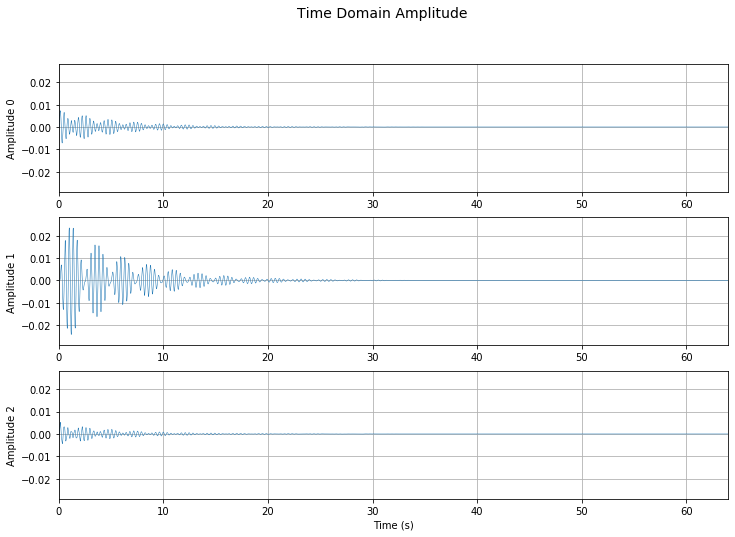

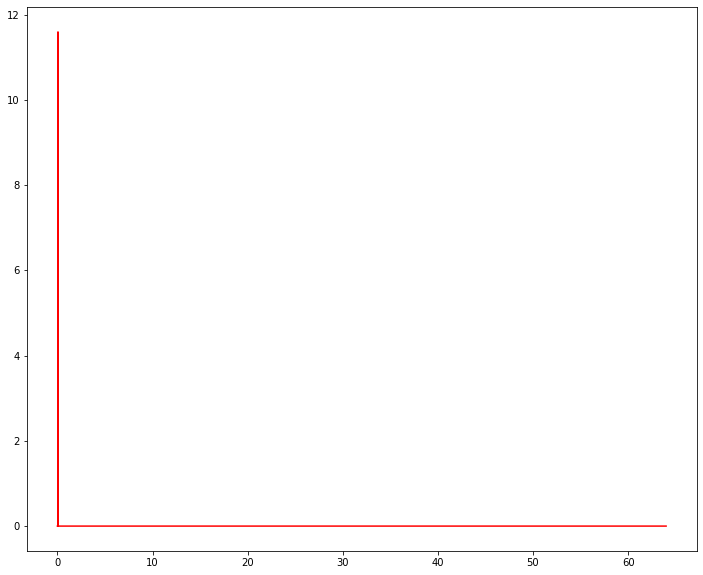

In [76]:
uk =  Fk.sdof_Duhamel(fk, zt)           # solve by Duhamel
ut =  MRPy(np.dot(Phi, uk), fs=uk.fs)   # back from modal space

ut.plot_time();
plt.figure(1, figsize=(12, 10), clear=True)
plt.plot(t, F[0],"r")


print('R.M.S. displacement of system mass: {0:6.3f}m'.format(ut[0].std()))
print('R.M.S. displacement of damper:      {0:6.3f}m'.format(ut[1].std()))
print('R.M.S. displacement of system mass:      {0:6.3f}m'.format(ut[2].std()))
